In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.stats
#import seaborn as sns
#sns.set(style="whitegrid")
import time
import seaborn as sns; sns.set()
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy
import random

/Users/renyuanxu/.pyenv/versions/3.6.5/envs/py365/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn):
    scale_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        scale_ext[r,:eff_date] = sigma_adjust1[r]*np.ones(int(eff_date))
        scale_ext[r,eff_date:] = d*sigma_adjust2[r]*np.ones(int(nn - eff_date))
    return scale_ext

In [3]:
def C_series(eff_dates,pr1,pr2,nn):
    C_ext = np.zeros((133,nn))
    for r in range(133):
        eff_date = int(eff_dates[r])
        C_ext[r,:eff_date] = pr1*np.ones(int(eff_date))
        C_ext[r,eff_date:] = pr2*np.ones(int(nn - eff_date))
    return C_ext

In [4]:
def SEIR_Policy_relax(init_vals, C_, Sigma_, p,f, params, d, eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn):
    ## input
    # nn is the number of days
    #S_0,E_0,I_0,R_0: dimension: A*R
    # C is a matrix in dimension R*R with compotnent c_(r,r')
    # p is vector in dimension A with each column equals to p_a
    S_0, E_0, I_0, A_0, D_0,R_0 = init_vals
    
    N_A, N_K = S_0.shape[0], S_0.shape[1]
      
    S, E, I, A, D, R = [S_0], [E_0], [I_0], [A_0], [D_0],[R_0]
    
    R_I = [R_0]
    R_A = [R_0]
    
    # N: total number of people in each class: matrix dimension A*R
    N = S_0 + E_0 + I_0 + R_0 +D_0+ A_0
    S_i, E_i, I_i, A_i, D_i, R_i = S_0.copy(), E_0.copy(), I_0.copy(), A_0.copy(), D_0.copy(),R_0.copy()
    
    R_i_I,R_i_A = R_0.copy(),R_0.copy()
    
    alpha, beta, gamma, kappa,pi  = params
    Sigma = Sigma_
    C = C_
    
    ### time-dependent parameters
    scale_ts = Sigma_adjust_Ext(eff_dates,sigma_adjust1,sigma_adjust2,d,nn)
    C_ts = C_series(eff_dates,1.0,0.2,nn)
    
    
    regional_real_cases = np.zeros((nn+1,N_A,N_K))
    regional_confirm_cases = np.zeros((nn+1,N_A,N_K))
    england_real_cases = np.zeros((nn+1,N_A))
    england_confirm_cases = np.zeros((nn+1,N_A))
    
    regional_real_cases[0,:,] = I_0
    england_real_cases[0] = np.sum(I_0)
    for region in range(N_K):
            for age in range(N_A):
                number = I_0[age,region]
                regional_confirm_cases[0,age,region] =  np.random.binomial(number, pi, 1)[0] 
    england_confirm_cases[0,:] = np.sum(regional_confirm_cases[0,:,:],axis=1)
    total_contact = 0
    # signal==0 means relax policy (not control)
    # signal > 0 means control 
    signals = np.zeros(nn)
    signals[:relax_day] = 1
    
    mask_base = np.arange(16)
    mask = (mask_base < 4) | (mask_base > 11)
    for t in range(nn):
        day_contact = 0
        signal = signals[t]
        Lambda = np.zeros((N_A,N_K))
        if signal > 0:
            #for r in range(N_K):
            C_r = C_ts[:,t]*C_ + (1-C_ts[:,t])*np.identity(133)
            Lambda += np.dot(Sigma[:,mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha *(kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:])
            Lambda += np.dot(Sigma[:,~mask], np.reshape(scale_ts[:,t], (1, -1)) * alpha * np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T))
            day_contact += (N * np.dot(np.reshape(np.sum(Sigma, axis=-1), (-1, 1)), np.reshape(scale_ts[:,t], (1, -1)))).flatten().sum()
            
                
                #for a in range(N_A):
                #    for a_prime in [0,1,2,3,12,13,14,15]:
                #        Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
                #    for a_prime in [4,5,6,7,8,9,10,11]:
                #        Lambda[a,r] += scale_ts[r,t] * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                #    day_contact += N[a,r] *scale_ts[r,t] *np.sum(Sigma[a,:])
        if signal ==0 :
            #for r in range(N_K):
            C_ts_tmp = relax
            C_r = C_ts_tmp*C_ + (1-C_ts_tmp)*np.identity(N_K)
            scale_ts_tmp = relax*sigma_adjust1 + (1-relax)*scale_ts[:,t] 
            Lambda += (alpha * np.dot(Sigma[:, mask], (kappa*I_i[mask,:]+A_i[mask,:])/N[mask,:] * scale_ts_tmp.reshape((1, -1))))
            Lambda += (alpha * np.dot(Sigma[:,~mask], np.dot((kappa*I_i[~mask,:]+A_i[~mask,:])/N[~mask,:], C_r.T) * scale_ts_tmp.reshape((1, -1))))
            day_contact  += (N * np.dot(Sigma.sum(axis=-1).reshape((-1, 1)), scale_ts_tmp.reshape((1, -1)))).flatten().sum()
            
                #C_ts_tmp = relax #np.min([1,relax*C_ts[r,t]])
                #C_r = C_ts_tmp*C_ + (1-C_ts_tmp)*np.identity(133)
                #scale_ts_tmp = relax*sigma_adjust1[r] + (1-relax)*scale_ts[r,t] 
                #for a in range(N_A):
                #    for a_prime in [0,1,2,3,12,13,14,15]:
                #        Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * (kappa*I_i[a_prime,r]+A_i[a_prime,r])/N[a_prime,r]
                #    
                #    for a_prime in [4,5,6,7,8,9,10,11]:
                #        Lambda[a,r] += scale_ts_tmp * alpha * Sigma[a,a_prime] * ((C_r[r,:]).dot((kappa*I_i[a_prime,:]+A_i[a_prime,:])/N[a_prime,:]))
                #    day_contact +=  N[a,r] *scale_ts_tmp*np.sum(Sigma[a,:])
                
                
        total_contact += day_contact      
        dI_i = np.zeros((N_A,N_K))
        dA_i = np.zeros((N_A,N_K))
        for a in range(N_A):
            dI_i[a,:] += p[a]*beta*E_i[a,:]
            dA_i[a,:] += (1-p[a])*beta*E_i[a,:]
        
        compartment_prob = np.array([(S_i*Lambda), dI_i, dA_i ,(gamma*f*I_i),(gamma*(1-f)*I_i),(gamma*A_i)]).reshape(6*N_A*N_K)

        compartment_prob = np.asarray(compartment_prob).astype(np.float64)
        ratio = np.sum(compartment_prob)
        if ratio > 0:
            compartment_prob /= np.sum(compartment_prob)
        else:
            total_contact += (nn-t)*day_contact 
            return S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact

        number_event = np.random.poisson(ratio,1)[0]
    
        ind = np.random.multinomial(number_event, compartment_prob, size=1)
        
        ind = ind.reshape(6,N_A,N_K)

        

        S_i += -ind[0,:,:]
        E_i += ind[0,:,:]-ind[1,:,:]-ind[2,:,:]
        I_i += ind[1,:,:]-ind[3,:,:]-ind[4,:,:]
        A_i += ind[2,:,:]-ind[5,:,:]
        D_i += ind[3,:,:]
        R_i += ind[4,:,:]+ind[5,:,:]
        
        R_i_A += ind[5,:,:]
        R_i_I += ind[4,:,:]
        
        S_i = (np.abs(S_i)+S_i)/2
        E_i = (np.abs(E_i)+E_i)/2
        A_i = (np.abs(A_i)+A_i)/2
        D_i = (np.abs(D_i)+D_i)/2
        I_i = (np.abs(I_i)+I_i)/2
        R_i = (np.abs(R_i)+R_i)/2
        
        R_i_I = (np.abs(R_i_I)+R_i_I)/2
        R_i_A = (np.abs(R_i_A)+R_i_A)/2
        
        
        regional_real_cases[t+1,:,:] = ind[1,:,:]
        england_real_cases[t+1,:] = np.sum(ind[1,:,:],axis=1)
        for region in range(N_K):
            for age in range(N_A):
                number = ind[1,age,region]
                regional_confirm_cases[t+1,age,region] =  np.random.binomial(number, pi, 1)[0] 
        
        today_confirm = np.sum(regional_confirm_cases[t+1,:,:],axis=1)
        england_confirm_cases[t+1,:] = today_confirm
        
        
        S.append(S_i.copy())
        E.append(E_i.copy())
        I.append(I_i.copy())
        A.append(A_i.copy())
        D.append(D_i.copy())
        R.append(R_i.copy())
        
        R_A.append(R_i_A.copy())
        R_I.append(R_i_I.copy())
        
        
        
        
         
    return S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases,total_contact

# Data Preparation

In [5]:
# social contact among age group
contact = pd.read_csv('data/contact_matrix_16_groups.csv')
social_m = np.array(contact[['matrix..0.5.', 'matrix..5.10.', 'matrix..10.15.', 'matrix..15.20.',
       'matrix..20.25.', 'matrix..25.30.', 'matrix..30.35.', 'matrix..35.40.',
       'matrix..40.45.', 'matrix..45.50.', 'matrix..50.55.', 'matrix..55.60.',
       'matrix..60.65.', 'matrix..65.70.', 'matrix..70.75.', 'matrix.75.']]).reshape(16,16)

Sigma = social_m

In [6]:
#contact mtrix
transport = pd.read_csv('data/CommuteMatrix-NUTS3.csv')
transport_mat = np.array(transport)[:,1:].astype(float)
C = transport_mat

In [7]:
covid_data = pd.read_csv('data/UK-COVID-data.csv')
covid_data_new = pd.DataFrame(columns = covid_data.columns)
region_order = list(transport['Unnamed: 0'])

In [8]:
for i in range(133):
    region = region_order[i]
    covid_data_new.loc[i] = covid_data[covid_data['id']==region].values[0]
    #covid_data_new2.loc[i] = covid_data2[covid_data2['id']==region].values[0]

In [9]:
## Sanity check
print('does all tables have the same region order:')
covid_order = list(covid_data_new['id'])
#covid_order2 = list(covid_data_new2['id'])

region_order = list(transport['Unnamed: 0'])

print(region_order ==covid_order)
#print(population_order==covid_order2)

does all tables have the same region order:
True


In [10]:
## Population data validation 
population = pd.read_csv('data/UK-COVID-data-with_ALL_age_groups.csv')
population = population[['id', 'Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]

In [11]:
population_new = pd.DataFrame(columns = population.columns)
for i in range(133):
    region = region_order[i]
    population_new.loc[i] = population[population['id']==region].values[0]

In [12]:
N_mat2 = np.array(population_new[['Y_LT5', 'Y5-9', 'Y10-14', 'Y15-19', 'Y20-24',
       'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49', 'Y50-54', 'Y55-59',
       'Y60-64', 'Y65-69', 'Y70-74', 'Y75-79', 'Y80-84', 'Y85-89','Y_GE90']]).T

N_mat = np.zeros((16,133))

N_mat[:15,:] = N_mat2[:15,:]

N_mat[-1,:] = np.sum(N_mat2[15:,],axis=0)
np.sum(N_mat)

56171302.0

In [13]:
## Population density
population_density = np.array(covid_data_new['population_density'])

In [14]:
initial_day = 15


In [15]:
N_A= 16
N_K = 133

In [16]:
real_cum_cases = np.sum(np.array(covid_data_new.iloc[0:133,(19+initial_day):103]).astype(float),axis = 0)

In [17]:
real_cum_cases_ind = np.cumsum(np.ones(len(real_cum_cases)))+initial_day

In [18]:
d_table =  pd.read_csv('data/d1d2_effdates_initialization_final_lowratio_133regions_16agegroups.csv')

initial_covid = np.array(d_table['initialization'])

sigma_adjust1 = np.array(d_table['d_adjust1'])
sigma_adjust2 = np.array(d_table['d_adjust2'])
simulation_eff_dates = np.array(d_table['adjust_dates'])

In [19]:
death_data = pd.read_csv('data/coronavirus-deaths_0615.csv')

cum_death_number = np.array(death_data[death_data['Area name']=='England'][::-1].iloc[9:]['Cumulative deaths'])

cum_death_number_ind = np.cumsum(np.ones(len(cum_death_number)))+initial_day

# Initialization

In [20]:
alpha = 0.055 #+ np.random.normal(0, 0.01, 1)[0]
beta = 0.2 #+ np.random.normal(0, 0.05, 1)[0]
gamma = 0.1 #+ np.random.normal(0, 0.02, 1)[0]
kappa = 0.5 # + np.random.normal(0, 0.05, 1)[0]

f0 = 0.002 
f1 = 0.002
f2 = 0.01
f3 = 0.01
f4 = 0.05
f5 = 0.05
f6 = 0.1
f7 = 0.1
f8 =  0.2
f9 = 0.2
f10 = 0.6
f11 = 0.6
f12 = 2.0
f13 = 2.0
f14 = 4.0
f15 = 7.5 


p0 = 0.075 
p1 =  0.075
p2 = 0.05
p3 = 0.05
p4 = 0.15
p5 = 0.15
p6 = 0.21
p7 = 0.21
p8 =  0.23 
p9 = 0.23 
p10 = 0.28
p11 = 0.28
p12 =  0.41
p13 =  0.41
p14 =  0.375
p15 = 0.375
p = [p0,p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15]
pi = 4.5/100
# 0.005,0.25,2,6
f = np.array([f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15]).reshape(16,1)/100
params =alpha, beta, gamma, kappa,pi

In [21]:
## initial population
init_sick = np.zeros((N_A,N_K))
init_sick_scale = np.zeros((N_A,N_K))
for a in [4,5,6,7,8,9,10,11]:
    init_sick[a,:] = initial_covid*(N_mat[a,:])/np.sum(N_mat[4:12,:],axis=0)

for a in [4,5,6,7,8,9,10,11]:
    init_sick_scale[a,:] = init_sick[a,:]/(p[a]*pi)
#init_sick[1,44] = 5
#init_sick[1,64] = 5
init_vals = N_mat-(init_sick_scale).astype(int),(init_sick_scale).astype(int), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K)), np.zeros((N_A,N_K))

In [22]:
nn=1000
scale=0.12

In [23]:
benchmark_total_contact = 0
for r in range(133):
    for a in range(16):
        benchmark_total_contact += N_mat[a,r]*sigma_adjust1[r]*nn*np.sum(Sigma[a,:])

In [24]:
benchmark_total_contact

613800527142.0557

In [40]:
lag=10

# Experiments

In [47]:
sns.set(font_scale=1.3)

In [25]:
relax = 0.4
relax_day = 120 # 210
nn = 1000

paths = 5

trags2 = np.zeros((nn+1,paths))
deaths2 = np.zeros((nn+1,paths))
trags_I2 = np.zeros((nn+1,paths))
costs2 = np.zeros(paths)



for path in range(paths):
    print(path)
    S,E,I,A,D,R,R_A,R_I,signals,regional_real_cases,england_real_cases,regional_confirm_cases,england_confirm_cases, total_contact =SEIR_Policy_relax(init_vals, C, Sigma,p,f, params,scale,simulation_eff_dates,sigma_adjust1,sigma_adjust2,relax,relax_day,nn)

    lenss = np.array(I).shape[0]
    trags2[:,path] = np.sum(england_confirm_cases,axis=1)
    trags_I2[:lenss,path] = np.sum(np.array(I),axis=(1,2))
    deaths2[:lenss,path] = np.sum(np.array(D),axis=(1,2))
    deaths2[lenss:,path] = np.sum(np.array(D),axis=(1,2))[-1]
    
    
    
    costs2[path] = benchmark_total_contact - total_contact
    

0
1
2
3
4


In [41]:
xx = np.cumsum(np.ones(nn))-1+lag


Text(0, 0.5, '$I_t$')

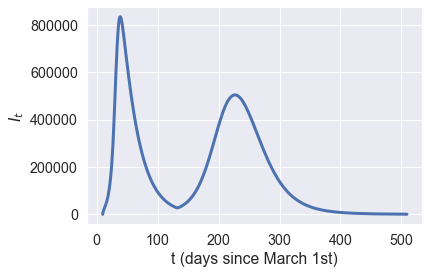

In [48]:
plt.plot(xx[:500],np.mean(trags_I2,axis=1)[:500],linewidth=3)
plt.xlabel('t (days since March 1st)')
plt.ylabel('$I_t$')

Text(0.5, 0, 't (days since March 1st)')

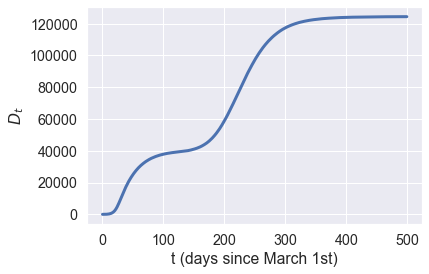

In [49]:
plt.plot(np.mean(deaths2,axis=1)[:500],linewidth=3)
plt.xlabel('t')
plt.ylabel('$D_t$')
plt.xlabel('t (days since March 1st)')
